In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal, ndimage
import time

class DisparityMap():
    def __init__(self, numDisparities, blockSize):
        self.numDisparities = numDisparities
        self.blockSize = blockSize

    def compute_for_color_input(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        l, w, h = imgL.shape
        disparityMap = np.zeros((l, w))
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, w-mid):
                b1 = imgR[i-mid:i+mid+1, j-mid:j+mid+1, :]
                errors = []
                for jj in range(j, min(j+self.numDisparities, w-mid)):
                    b2 = imgL[i-mid:i+mid+1, jj-mid:jj+mid+1, :]
                    errors.append(np.sum(abs(b1-b2)))
                disparityMap[i, j] = np.argmin(errors)
            print("i=", i)
        disparityMap = disparityMap/self.numDisparities
        return disparityMap
    
    def compute_for_gray_input(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        l, w = imgL.shape
        disparityMap = np.zeros((l, w))
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, w-mid):
                b1 = imgR[i-mid:i+mid+1, j-mid:j+mid+1]
                errors = []
                for jj in range(j, min(j+self.numDisparities, w-mid)):
                    b2 = imgL[i-mid:i+mid+1, jj-mid:jj+mid+1]
                    errors.append(np.sum(abs(b1-b2)))
                disparityMap[i, j] = np.argmin(errors)
        disparityMap = disparityMap/self.numDisparities
        return disparityMap

    def using_convolution(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        difference = []
        l, w = imgL.shape
        for i in range(self.numDisparities):
            temp = np.zeros((l, w), dtype = np.float)
            temp[:, :w-i] = abs(imgR[:, :w-i]-imgL[:, i:])
            temp = ndimage.uniform_filter(temp, self.blockSize)
            difference.append(temp.copy())
        difference = np.array(difference)

        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmin(difference[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap
    
    def using_bilateral_filter(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        difference = []
        l, w = imgL.shape
        for i in range(self.numDisparities):
            temp = np.zeros((l, w), dtype = np.uint8)
            temp[:, :w-i] = abs(imgR[:, :w-i]-imgL[:, i:])
            temp = cv2.bilateralFilter(temp, 17, 13, 10)
            temp = temp.astype(np.float)
            difference.append(temp.copy())
        difference = np.array(difference)

        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmin(difference[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap

In [ ]:
# imgL = cv2.imread('tsukuba_l.png', 0)
# imgR = cv2.imread('tsukuba_r.png', 0)

# imgL = cv2.imread('2001/cones/im2.png', 0)
# imgR = cv2.imread('2001/cones/im6.png', 0)

# imgL = cv2.imread('2001/teddy/im2.png', 0)
# imgR = cv2.imread('2001/teddy/im6.png', 0)

# imgL = cv2.imread('2001/sawtooth/im2.ppm', 0)
# imgR = cv2.imread('2001/sawtooth/im6.ppm', 0)

imgL = cv2.imread('2001/venus/im2.ppm', 0)
imgR = cv2.imread('2001/venus/im6.ppm', 0)
blocksize = 11
numdisparities = 64
disparity = DisparityMap(numDisparities=numdisparities, blockSize=blocksize)

disparityMap1 = disparity.using_convolution(imgL, imgR)
plt.imshow(disparityMap1, 'gray')
plt.show()

r, c = imgL.shape
block_size = 16
mid = block_size//2
disparityMap1 = disparityMap1.astype(np.int64)
disparityMap2 = disparityMap1.copy()
for i in range(2*mid, r-2*mid):
    for j in range(2*mid, min(c-numdisparities-mid, c-2*mid)):
        temp = disparityMap1[i-mid:i+mid, j-mid:j+mid]
        val = np.bincount(temp.reshape(1, block_size**2)[0]).argmax()
        disparityMap2[i, j] = val

plt.imshow(disparityMap2, 'gray')
plt.show()     

In [ ]:
################################################################
#ground_truth = cv2.imread('2001/cones/disp6.png', 0)/4
#ground_truth = cv2.imread('2001/teddy/disp6.png', 0)/4
# ground_truth = cv2.imread('2001/sawtooth/disp6.pgm', 0)/8
ground_truth = cv2.imread('2001/venus/disp6.pgm', 0)/8
r, c = ground_truth.shape
ground_truth[:int(blocksize/2), :] = 0
ground_truth[:, :int(blocksize/2)] = 0
ground_truth[r-int(blocksize/2):, :] = 0
ground_truth[:, c-numdisparities:] = 0
plt.imshow(ground_truth, 'gray')
plt.show()

################################################################
##Calculating error
error1 = abs(ground_truth-disparityMap1)>1
error_cnt1 = sum([sum(error1[i][:]) for i in range(r)])
plt.imshow(error1, 'gray')
plt.show()

error2 = abs(ground_truth-disparityMap2)>1
error_cnt2 = sum([sum(error2[i][:]) for i in range(r)])
plt.imshow(error2, 'gray')
plt.show()

# error3 = abs(ground_truth-disparityMap3)>1
# error_cnt3 = sum([sum(error3[i][:]) for i in range(r)])
# plt.imshow(error3, 'gray')
# plt.show()

# error4 = abs(ground_truth-disparityMap4)>1
# error_cnt4 = sum([sum(error4[i][:]) for i in range(r)])
# plt.imshow(error4, 'gray')
# plt.show()

#Printing errors
print("Bad Pixels Error in percentage: ", 100*error_cnt1/(r*c))
print("Bad Pixels Error in percentage: ", 100*error_cnt2/(r*c))
# print("Bad Pixels Error in percentage: ", 100*error_cnt3/(r*c))
# print("Bad Pixels Error in percentage: ", 100*error_cnt4/(r*c))

In [ ]:
imgL = cv2.imread('2001/sawtooth/im2.ppm', 0)
imgR = cv2.imread('2001/sawtooth/im6.ppm', 0)
plt.imshow(imgL, 'gray')
plt.show()
plt.imshow(imgR, 'gray')
plt.show()

In [ ]:
disparityMap1 = disparityMap1.astype(np.uint8)
bilateral = cv2.bilateralFilter(disparityMap1, 5, 13, 10)
plt.imshow(bilateral, 'gray')
plt.show()

10.390156984329224


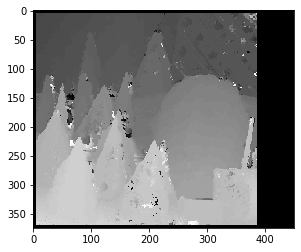

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal, ndimage
import time

class DisparityMap():
    def __init__(self, numDisparities, blockSize):
        self.numDisparities = numDisparities
        self.blockSize = blockSize

    def using_convolution(self, imgL, imgR):
        imgL = imgL.astype(np.float)/255
        imgR = imgR.astype(np.float)/255
        
        kernel_61_1 = np.ones((61, 1))
        kernel_1_61 = np.ones((1, 61))
        kernel_11_11 = np.ones((11, 11))
        kernel_3_3 = np.ones((3, 3))
        
        global errors_61_1, out
        errors_61_1 = []
        errors_1_61 = []
        errors_11_11 = []
        errors_3_3 = []
        l, w = imgL.shape
        for i in range(self.numDisparities):
            temp = np.zeros((l, w), dtype = np.float)
            temp[:, :w-i] = abs(imgR[:, :w-i]-imgL[:, i:])
            
            error_61_1 = signal.convolve2d(temp, kernel_61_1, boundary='symm', mode='same')/61
            error_1_61 = signal.convolve2d(temp, kernel_1_61, boundary='symm', mode='same')/61
            error_11_11 = signal.convolve2d(temp, kernel_11_11, boundary='symm', mode='same')/121
            error_3_3 = signal.convolve2d(temp, kernel_3_3, boundary='symm', mode='same')/9
            
            errors_61_1.append(error_61_1.copy())
            errors_1_61.append(error_1_61.copy())
            errors_11_11.append(error_11_11.copy())
            errors_3_3.append(error_3_3.copy())
        
        errors_61_1 = np.array(errors_61_1)
        errors_1_61 = np.array(errors_1_61)
        errors_11_11 = np.array(errors_11_11)
        errors_3_3 = np.array(errors_3_3)
        
        errors_61_1 = np.maximum(errors_61_1, errors_1_61) #Replacing the same array to not waste space xD
        out = np.multiply(errors_61_1, errors_11_11)
        out = np.multiply(out, errors_3_3)
        
        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                #min_idx = np.argmin(out[:,i,j])
                #disparityMap[i, j] = min_idx if out[min_idx,i,j]<0.01 else 0
                disparityMap[i, j] = np.argmin(out[:,i,j])
        disparityMap = disparityMap
        return disparityMap

# imgL = cv2.imread('tsukuba_l.png', 0)
# imgR = cv2.imread('tsukuba_r.png', 0)
imgL = cv2.imread('2001/cones/im2.png', 0)
imgR = cv2.imread('2001/cones/im6.png', 0)
disparity = DisparityMap(numDisparities=64, blockSize=11)

t1 = time.time()
disparityMap1 = disparity.using_convolution(imgL, imgR)
t2 = time.time()
print(t2-t1)
plt.imshow(disparityMap1, 'gray')
plt.show()

disparityMap1 = disparityMap1*2
disparityMap1 = disparityMap1.astype(np.uint8)

In [ ]:
bilateral = cv2.bilateralFilter(disparityMap1, 3, 3, 3) 
plt.imshow(bilateral, 'gray')
plt.show()

In [ ]:
import open3d as o3d
l, w = imgL.shape
imgRo3d = o3d.io.read_image('2001/cones/im2.png')
depth = np.zeros((l, w), dtype=np.uint16)
focal_length = 200
baseline = 16
for i in range(l):
    for j in range(w):
        if disparityMap1[i, j]>1:
            depth[i, j] = focal_length*baseline/disparityMap1[i, j]

deptho3d = o3d.geometry.Image(depth)
rgbd = o3d.create_rgbd_image_from_color_and_depth(imgRo3d, deptho3d, convert_rgb_to_intensity = False)
a = o3d.camera.PinholeCameraIntrinsic()
a.set_intrinsics(w, l, float(focal_length), float(focal_length), w/2, l/2)
pcd = o3d.create_point_cloud_from_rgbd_image(rgbd, a)
# flip the orientation, so it looks upright, not upside-down
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
o3d.draw_geometries([pcd])    # visualize the point cloud

### Sum of Absolute Difference(SAD) using Multi Block Matching

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy import signal, ndimage
import time

class DisparityMap():
    def __init__(self, numDisparities, blockSize):
        self.numDisparities = numDisparities
        self.blockSize = blockSize
    
    def SAD(self, imgL, imgR):
        imgL = imgL.astype(np.float)
        imgR = imgR.astype(np.float)
        difference = []
        l, w = imgL.shape
        for i in range(self.numDisparities):
            temp = np.zeros((l, w), dtype = np.float)
            temp[:, :w-i] = abs(imgR[:, :w-i]-imgL[:, i:])
            temp = ndimage.uniform_filter(temp, self.blockSize)
            difference.append(temp.copy())
        difference = np.array(difference)

        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                disparityMap[i, j] = np.argmin(difference[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap

    def SAD_with_MBM(self, imgL, imgR):
        imgL = imgL.astype(np.float)/255
        imgR = imgR.astype(np.float)/255
        
        kernel_61_1 = np.ones((61, 1))
        kernel_1_61 = np.ones((1, 61))
        kernel_11_11 = np.ones((11, 11))
        kernel_3_3 = np.ones((3, 3))
        
        errors_61_1 = []
        errors_1_61 = []
        errors_11_11 = []
        errors_3_3 = []
        l, w = imgL.shape
        for i in range(self.numDisparities):
            temp = np.zeros((l, w), dtype = np.float)
            temp[:, :w-i] = abs(imgR[:, :w-i]-imgL[:, i:])
            
            error_61_1 = signal.convolve2d(temp, kernel_61_1, boundary='symm', mode='same')/61
            error_1_61 = signal.convolve2d(temp, kernel_1_61, boundary='symm', mode='same')/61
            error_11_11 = signal.convolve2d(temp, kernel_11_11, boundary='symm', mode='same')/121
            error_3_3 = signal.convolve2d(temp, kernel_3_3, boundary='symm', mode='same')/9
            
            errors_61_1.append(error_61_1.copy())
            errors_1_61.append(error_1_61.copy())
            errors_11_11.append(error_11_11.copy())
            errors_3_3.append(error_3_3.copy())
        
        errors_61_1 = np.array(errors_61_1)
        errors_1_61 = np.array(errors_1_61)
        errors_11_11 = np.array(errors_11_11)
        errors_3_3 = np.array(errors_3_3)
        
        errors_61_1 = np.maximum(errors_61_1, errors_1_61) #Replacing the same array to not waste space xD
        out = np.multiply(errors_61_1, errors_11_11)
        out = np.multiply(out, errors_3_3)
        
        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                #min_idx = np.argmin(out[:,i,j])
                #disparityMap[i, j] = min_idx if out[min_idx,i,j]<0.01 else 0
                disparityMap[i, j] = np.argmin(out[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap
    
    def SAD_with_input_kernels(self, imgL, imgR, kernels):
        imgL = imgL.astype(np.float)/255
        imgR = imgR.astype(np.float)/255
        
        global errors
        errors = [[] for i in range(len(kernels))]
        
        l, w = imgL.shape
        for i in range(self.numDisparities):
            temp = np.zeros((l, w), dtype = np.float)
            temp[:, :w-i] = abs(imgR[:, :w-i]-imgL[:, i:])
            
            error = [[] for i in range(len(kernels))]
            for i in range(len(kernels)):
                kx, ky = kernels[i].shape
                error[i] = signal.convolve2d(temp, kernels[i], boundary='symm', mode='same')/(kx*ky)
                
            for i in range(len(kernels)):
                errors[i].append(error[i].copy())
        
        for i in range(len(kernels)):
            errors[i] = np.array(errors[i])
        
        out = errors[0]
        for i in range(1, len(kernels)):
            out = np.multiply(out, errors[i])
        
        disparityMap = np.zeros((l, w), dtype=np.float)
        mid = int(self.blockSize/2)
        for i in range(mid, l-mid):
            for j in range(mid, min(w-self.numDisparities, w-mid)):
                #min_idx = np.argmin(out[:,i,j])
                #disparityMap[i, j] = min_idx if out[min_idx,i,j]<0.01 else 0
                disparityMap[i, j] = np.argmin(out[:,i,j])
        #disparityMap = disparityMap/self.numDisparities
        return disparityMap
    
    #Generating Locally Consistent Disparity Map
    def LCDM(self, disparityMap, kernel):
        disparityMap = disparityMap.astype(np.int64)
        output = disparityMap.copy()
        r, c = imgL.shape
        row_mid, col_mid = kernel[0]//2, kernel[1]//2
        
        for i in range(2*row_mid, r-2*row_mid):
            for j in range(2*col_mid, min(c-numdisparities-col_mid, c-2*col_mid)):
                temp = disparityMap[i-row_mid:i+row_mid+1, j-col_mid:j+col_mid+1]
                val = np.bincount(temp.reshape(1, kernel[0]*kernel[1])[0]).argmax()
                output[i, j] = val
        return output

In [2]:
# imgL = cv2.imread('tsukuba_l.png', 0)
# imgR = cv2.imread('tsukuba_r.png', 0)

imgL = cv2.imread('2001/cones/im2.png', 0)
imgR = cv2.imread('2001/cones/im6.png', 0)
ground_truth = cv2.imread('2001/cones/disp6.png', 0)/4

# imgL = cv2.imread('2001/teddy/im2.png', 0)
# imgR = cv2.imread('2001/teddy/im6.png', 0)
# ground_truth = cv2.imread('2001/teddy/disp6.png', 0)/4

# imgL = cv2.imread('2001/sawtooth/im2.ppm', 0)
# imgR = cv2.imread('2001/sawtooth/im6.ppm', 0)
# ground_truth = cv2.imread('2001/sawtooth/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/venus/im2.ppm', 0)
# imgR = cv2.imread('2001/venus/im6.ppm', 0)
# ground_truth = cv2.imread('2001/venus/disp6.pgm', 0)/8

# imgL = cv2.imread('2001/barn1/im2.ppm', 0)
# imgR = cv2.imread('2001/barn1/im6.ppm', 0)
# ground_truth = cv2.imread('2001/barn1/disp6.pgm', 0)/8

blocksize = 11
numdisparities = 64
disparity = DisparityMap(numDisparities=numdisparities, blockSize=blocksize)

t1 = time.time()
disparityMap1 = disparity.SAD(imgL, imgR)
t2 = time.time()
print("SAD:", (t2-t1))
disparityMap2 = disparity.LCDM(disparityMap1, (11, 11))

t3 = time.time()
disparityMap3 = disparity.SAD_with_MBM(imgL, imgR)
t4 = time.time()
print("MBM+SAD:", (t4-t3))
disparityMap4 = disparity.LCDM(disparityMap3, (11, 11))

###############################################################
##Cropping the ground truth
r, c = ground_truth.shape
ground_truth[:int(blocksize/2), :] = 0
ground_truth[:, :int(blocksize/2)] = 0
ground_truth[r-int(blocksize/2):, :] = 0
ground_truth[:, c-numdisparities:] = 0

##Calculating error
error1 = abs(ground_truth-disparityMap1)>1
error_per1 = np.round(100*sum(error1.reshape(r*c, 1))[0]/(r*c), 2)

error2 = abs(ground_truth-disparityMap2)>1
error_per2 = np.round(100*sum(error2.reshape(r*c, 1))[0]/(r*c), 2)

error3 = abs(ground_truth-disparityMap3)>1
error_per3 = np.round(100*sum(error3.reshape(r*c, 1))[0]/(r*c), 2)

error4 = abs(ground_truth-disparityMap4)>1
error_per4 = np.round(100*sum(error4.reshape(r*c, 1))[0]/(r*c), 2)

SAD: 0.6502611637115479
MBM+SAD: 10.419725894927979


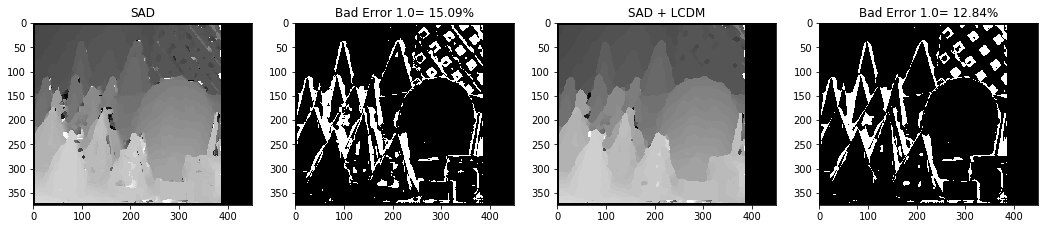

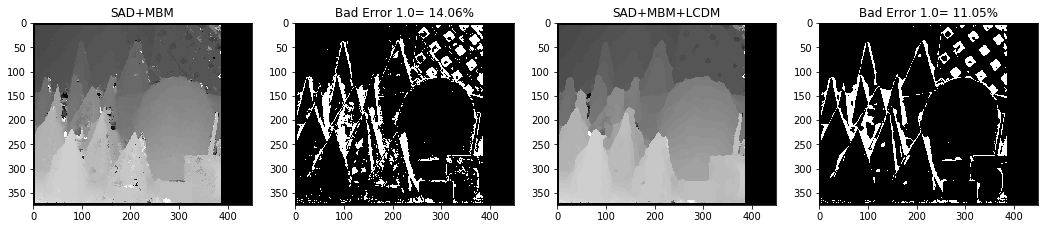

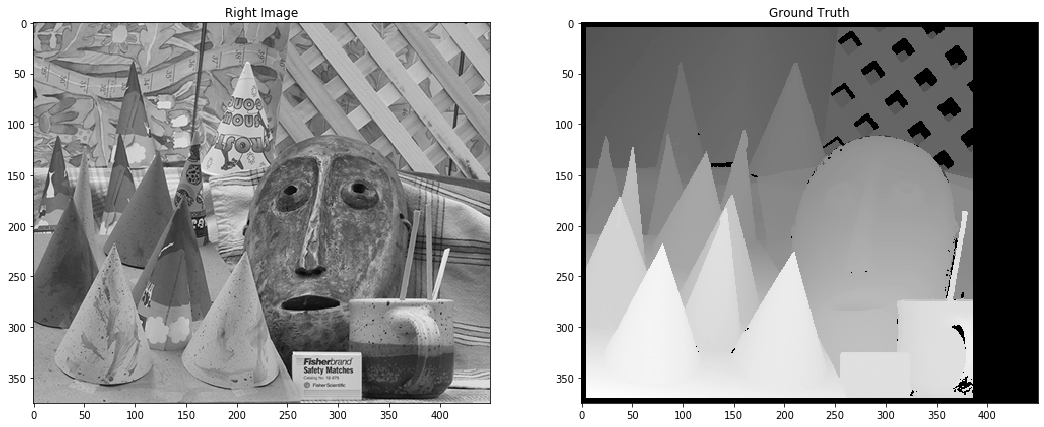

In [146]:
##################################################################
plt.figure(figsize=(18, 72))
plt.subplot(141)
plt.imshow(disparityMap1, 'gray')
plt.title('SAD')

plt.subplot(142)
plt.imshow(error1, 'gray')
plt.title('Bad Error 1.0= '+str(error_per1)+'%')

plt.subplot(143)
plt.imshow(disparityMap2, 'gray')
plt.title('SAD + LCDM')

plt.subplot(144)
plt.imshow(error2, 'gray')
plt.title('Bad Error 1.0= '+str(error_per2)+'%')
plt.show()

##################################
plt.figure(figsize=(18, 72))
plt.subplot(141)
plt.imshow(disparityMap3, 'gray')
plt.title('SAD+MBM')

plt.subplot(142)
plt.imshow(error3, 'gray')
plt.title('Bad Error 1.0= '+str(error_per3)+'%')

plt.subplot(143)
plt.imshow(disparityMap4, 'gray')
plt.title('SAD+MBM+LCDM')

plt.subplot(144)
plt.imshow(error4, 'gray')
plt.title('Bad Error 1.0= '+str(error_per4)+'%')
plt.show()

###################################################################
plt.figure(figsize=(18, 27))
plt.subplot(121)
plt.imshow(imgR, 'gray')
plt.title('Right Image')

plt.subplot(122)
plt.imshow(ground_truth, 'gray')
plt.title('Ground Truth')
plt.show()

In [ ]:
imgL = cv2.imread('tsukuba_l.png', 0)
imgR = cv2.imread('tsukuba_r.png', 0)
disparity = DisparityMap(numDisparities=16, blockSize=11)

disparityMap1 = disparity.SAD(imgL, imgR)
plt.imshow(disparityMap1, 'gray')
plt.show()

disparityMap2 = disparity.SAD_with_MBM(imgL, imgR)
plt.imshow(disparityMap2, 'gray')
plt.show()

kernel_61_1 = np.ones((61, 1))
kernel_1_61 = np.ones((1, 61))
kernel_11_11 = np.ones((11, 11))
kernel_3_3 = np.ones((3, 3))

kernels = []
#kernels.append(kernel_61_1)
#kernels.append(kernel_1_61)
kernels.append(kernel_11_11)
kernels.append(kernel_3_3)

disparityMap3 = disparity.SAD_with_input_kernels(imgL, imgR, kernels)
plt.imshow(disparityMap3, 'gray')
plt.show()

In [ ]:
# imgL = cv2.imread('tsukuba_l.png', 0)
# imgR = cv2.imread('tsukuba_r.png', 0)
# disparity = DisparityMap(numDisparities=16, blockSize=11)
# stereo = cv2.StereoBM_create(numDisparities=16, blockSize=11)

# t1 = time.time()
# disparityMap1 = disparity.compute_for_gray_input(imgL, imgR)
# t2 = time.time()
# disparityMap2 = disparity.using_convolution(imgL, imgR)
# t3 = time.time()
# disparityMap3 = stereo.compute(imgL,imgR)
# t4 = time.time()

# plt.imshow(disparityMap1, 'gray')
# plt.show()
# plt.imshow(disparityMap2, 'gray')
# plt.show()
# plt.imshow(disparityMap3, 'gray')
# plt.show()

# print(t2-t1, t3-t2, t4-t3)

# Processing_Times = [t2-t1, t3-t2, t4-t3]
# x = ['Without convolution', 'With convolution', 'OpenCV']
# x_position = [i for i in range(len(x))]
# plt.bar(x_position, Processing_Times, color='blue')
# plt.xlabel("Method")
# plt.ylabel("Processing Time")
# plt.title(" Processing Time Vs Method ")
# plt.xticks(x_position, x)
# plt.show()

In [ ]:
################################################################
#Defining different kernel sizes
kernel_61_1 = np.ones((81, 1))
kernel_1_61 = np.ones((1, 81))
kernel_11_11 = np.ones((11, 11))
kernel_3_3 = np.ones((3, 3))

kernels = []
kernels.append(kernel_61_1)
kernels.append(kernel_1_61)
kernels.append(kernel_11_11)
kernels.append(kernel_3_3)

disparityMap3 = disparity.SAD_with_input_kernels(imgL, imgR, kernels)
plt.imshow(disparityMap3, 'gray')
plt.show()